# Cutting-Edge project - Milliman


- Members: **Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
- Group 2
- Professional partner: **[Milliman](https://www.milliman.com/en/)**

*January 2023 - Present*

---

## Preliminaries

To execute this Jupyter Notebook on a local environment or on a Google Colab/Binder online system, please make sure you have all the prerequisites installed.

- If you are using **`pip`** for packaging management, please run:

In [1]:
#!pip install -r requirements.txt

- If you are using **`pip3`** for packaging management, please run:

In [2]:
#!pip3 install -r requirements.txt

- If you are using **`conda`** (Anaconda) for packaging management, please run:

In [3]:
#!conda install --yes --file requirements.txt

---

The next cell imports all the required Python modules.

In [1]:
# Main functions
from src.Constants import *
from src.Utils import *

# Model simulation
from src.EquityModel import *
from src.RatesModel import *
from src.Vasicek import *
from src.CIR import *
from src.HullWhite import *
from src.BlackScholes import *

# Pricing
from src.Pricer import *
from src.EuropeanPricer import *
from src.AsianPricer import *

In [2]:
Utils.get_multiprocessing_infos()

{'AVAILABLE_CPU_CORES': 8, 'MP_ACTIVE_CHILDREN': [], 'MP_CPU_COUNT': 8}

## Interest rates modelling

### Vasicek

In [6]:
# Default Vasicek model
model = Vasicek(0.01875, 0.20, 0.01, 0.012) # r0, kappa, theta, sigma

In [7]:
# Displaying information on Vasicek model
model

Vasicek model (r0 = 0.01875, kappa = 0.2, theta = 0.01, eta = 0.012))

In [8]:
# Casting the results into a pandas DataFrame
df = Utils.cast_df(model.simulate_euler(T=3, N = 1000))

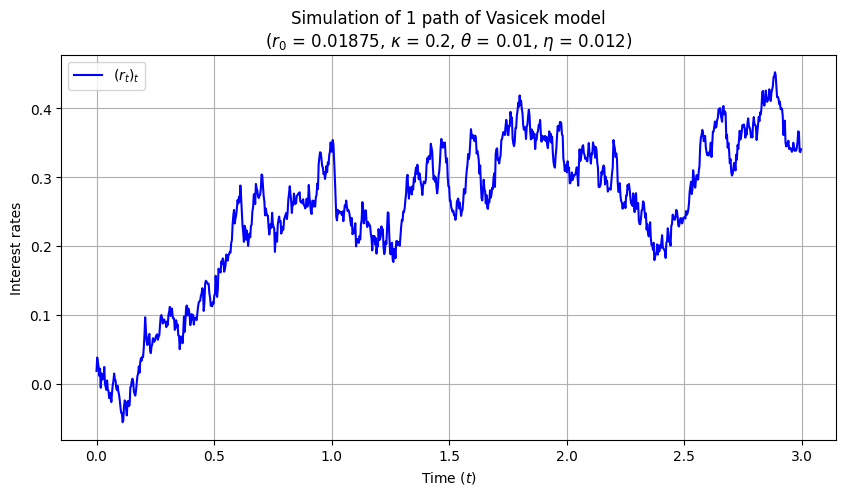

In [10]:
# Simulation of a trajectory
_ = df.plot(color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of Vasicek model\n{model.get_parameter_string()}")
_ = plt.legend()

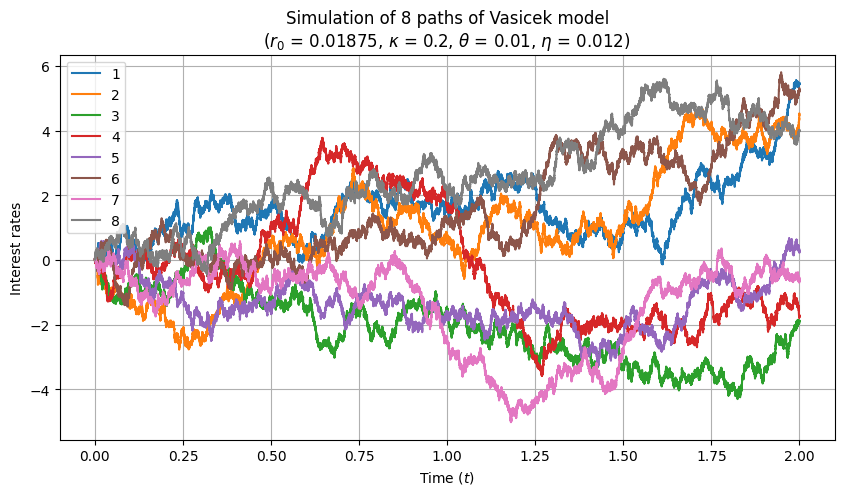

In [11]:
# Simulation of several trajectories
NB_TRAJECTORIES = 8
_ = Utils.cast_df(model.simulate_paths(NB_TRAJECTORIES, T = 2)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Vasicek model\n{model.get_parameter_string()}")
_ = plt.legend()

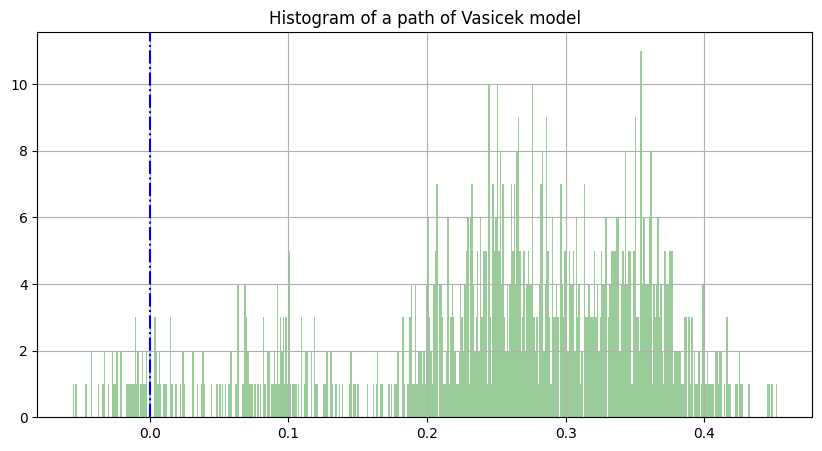

In [12]:
# Histogram of a path
_ = df["r"].hist(bins=int(5e2), color="green", alpha=0.4)
_ = plt.title("Histogram of a path of Vasicek model")
_ = plt.axvline(x = 0, ls = "-.", color="blue")

In [8]:
# Normality test (Shapiro-Wilk + Jarque-Bera)
TEST_THRESHOLD_ALPHA = 5e-2 # Threshold for p-value

# Definition of normality tests (Shapiro-Wilf + Jarque-Bera)
normtest_shapiro = lambda x: scipy.stats.shapiro(x).pvalue > TEST_THRESHOLD_ALPHA 
normtest_jarquebera = lambda x:scipy.stats.jarque_bera(x).pvalue > TEST_THRESHOLD_ALPHA

### Cox-Ingersoll-Ross (CIR)

In [13]:
# Default CIR model
model = CIR(0.4, 0.20, 0.01, 0.12)

In [14]:
# Displaying information on Vasicek model
model

CIR model (r0 = 0.4, kappa = 0.2, theta = 0.01, sigma = 0.12))

In [15]:
# Casting the results into a pandas DataFrame
df = Utils.cast_df(model.simulate_euler(T=3))

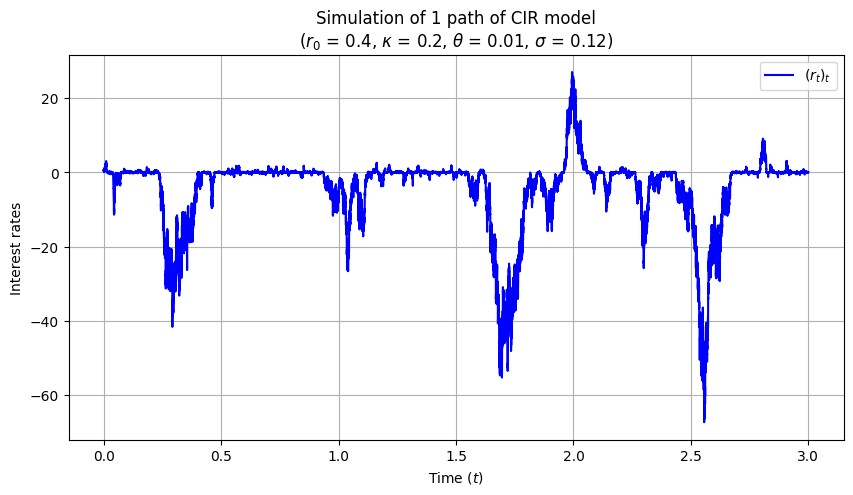

In [16]:
# Simulation of a trajectory
_ = df.plot(color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of CIR model\n{model.get_parameter_string()}")
model.plot_feller_line()

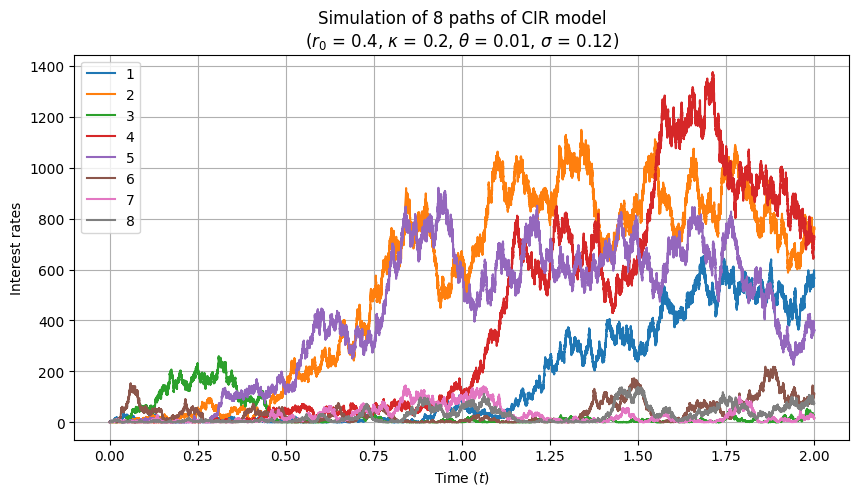

In [17]:
# Simulation of several trajectories
NB_TRAJECTORIES = 8
_ = Utils.cast_df(model.simulate_paths(NB_TRAJECTORIES, scheme=Constants.Scheme.MILSTEIN, T=2)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of CIR model\n{model.get_parameter_string()}")
_ = plt.legend()

**Remark**: Strange behavior of the simulated curves because of the $\sqrt{\bullet}$ with negative rates when Feller condition is not satisfied.
- To be studied (one alternative is to add $\sqrt{|\bullet|}$ to handle negative rates (created by floating point operations)

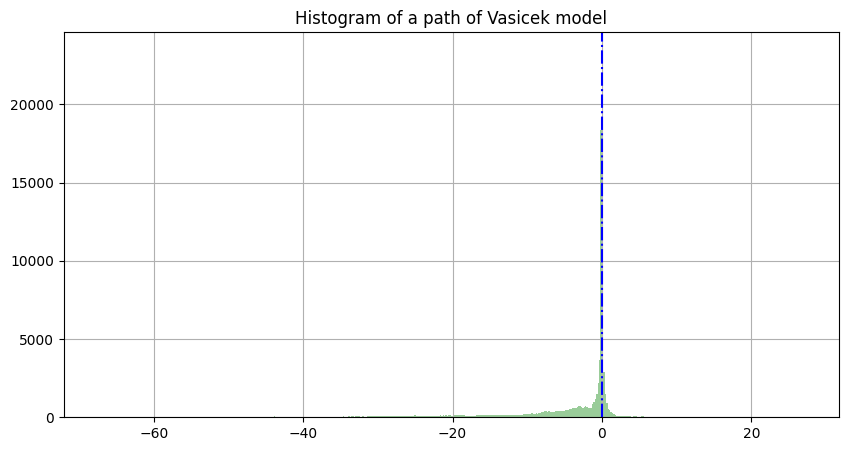

In [18]:
# Histogram of a path
_ = df["r"].hist(bins=int(5e2), color="green", alpha=0.4)
_ = plt.title("Histogram of a path of Vasicek model")
_ = plt.axvline(x = 0, ls = "-.", color="blue")

### Hull & White (HW) $\diamond$ Extended Vasicek

**Protocol**: Gathering the input term structure of interest rates in order to construct the $\theta : \left[0, T\right] \longrightarrow \mathbb{R}$ deterministic functional.

In [19]:
# Setting up a random evaluation Date
today_date = ql.Date(31,1,2013)
ql.Settings.instance().setEvaluationDate(today_date)

# Setting up the yield termstructure
forward_rate = 0.04875825 #5e-3
rate = ql.SimpleQuote(forward_rate)
rate_handle = ql.QuoteHandle(rate)

# Setting up the day count convention to Actual/365
day_count = ql.Actual365Fixed() 
# day_count = ql.Thirty360(ql.Thirty360.BondBasis)

# Creating the discount curve with its own handler
discount_curve = ql.FlatForward(today_date, rate_handle, day_count)
discount_curve.enableExtrapolation()

# Creating the handler
handler_YTS = ql.YieldTermStructureHandle(discount_curve)

The `yieldTermStructure` object provides an method which gives us the discount factor for a particular date (`QuantLib.Date` object) or time in years (with 0 = `evaluationDate`). This method is called `discount()`.  

We are using the **numpy** method `vectorize` to apply this function on arrays or list of times and then generate a plot of the discount curve.

**Reference**: 
1. https://ipythonquant.wordpress.com/2015/04/04/a-brief-introduction-to-the-quantlib-in-python/

In [20]:
discount = np.vectorize(handler_YTS.discount)
time_horizon = np.arange(0, 10, 1/12)

In [21]:
d = discount(time_horizon)
d

array([1.        , 0.99594506, 0.99190655, 0.98788443, 0.98387861,
       0.97988904, 0.97591565, 0.97195836, 0.96801713, 0.96409187,
       0.96018253, 0.95628905, 0.95241135, 0.94854937, 0.94470306,
       0.94087234, 0.93705716, 0.93325744, 0.92947313, 0.92570417,
       0.92195049, 0.91821204, 0.91448874, 0.91078054, 0.90708737,
       0.90340919, 0.89974591, 0.89609749, 0.89246387, 0.88884498,
       0.88524076, 0.88165116, 0.87807611, 0.87451556, 0.87096945,
       0.86743772, 0.86392031, 0.86041716, 0.85692822, 0.85345342,
       0.84999272, 0.84654604, 0.84311335, 0.83969457, 0.83628965,
       0.83289855, 0.82952119, 0.82615753, 0.8228075 , 0.81947107,
       0.81614816, 0.81283872, 0.80954271, 0.80626006, 0.80299072,
       0.79973464, 0.79649176, 0.79326203, 0.79004539, 0.7868418 ,
       0.7836512 , 0.78047354, 0.77730877, 0.77415682, 0.77101766,
       0.76789123, 0.76477747, 0.76167634, 0.75858779, 0.75551176,
       0.7524482 , 0.74939706, 0.7463583 , 0.74333186, 0.74031

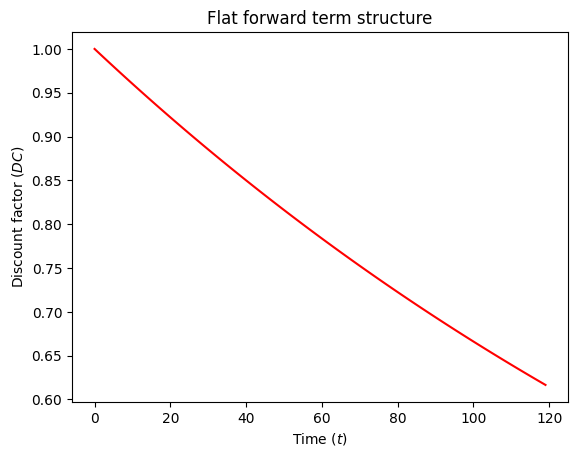

In [22]:
_ = pd.Series(d).plot(color="red")
_ = plt.title("Flat forward term structure")
_, _ = plt.xlabel("Time ($t$)"), plt.ylabel("Discount factor ($DC$)")

## Equity modelling

### Generation of 2 $\rho$-correlated Brownian motions

<span style="color:black"><b>Remark</b>: We have to take into account the parameter $\rho \in \left[-1, 1\right]$ as the correlation between the two Brownian motions.</span>

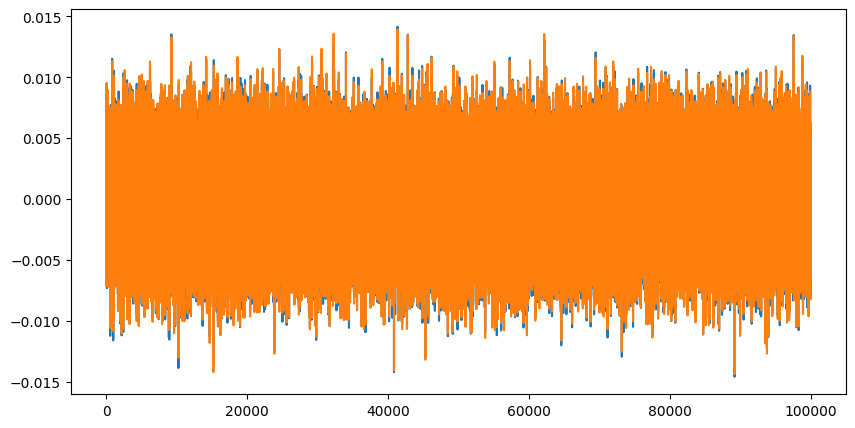

In [19]:
# Generation of Gaussian increments (Gaussian sequences)
for path in Utils.generate_correlated_gaussians(rho=0.99):
    plt.plot(path)

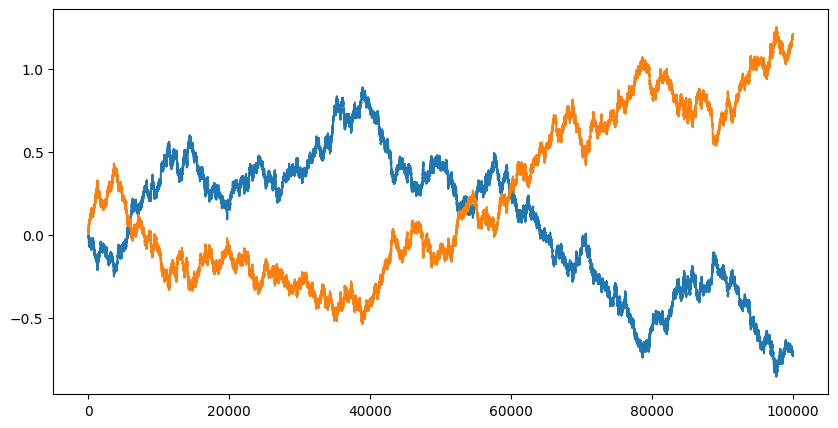

In [21]:
# Generation of Brownian motions (Cumulative sum of Gaussian increments)
for path in Utils.generate_correlated_brownians(rho=-0.9):
    plt.plot(path)

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Constant volatility</span>

In [22]:
S0 = 1
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

In [23]:
d = model.simulate_euler(T=4.2, getRates=True)
df = pd.DataFrame(d)
df.head()

,t,S,r
0,0.000000,1.000000,0.400000
1,0.000042,1.001458,0.399835
2,0.000084,1.004047,0.399641
3,0.000126,1.003696,0.399663
4,0.000168,1.003145,0.399371


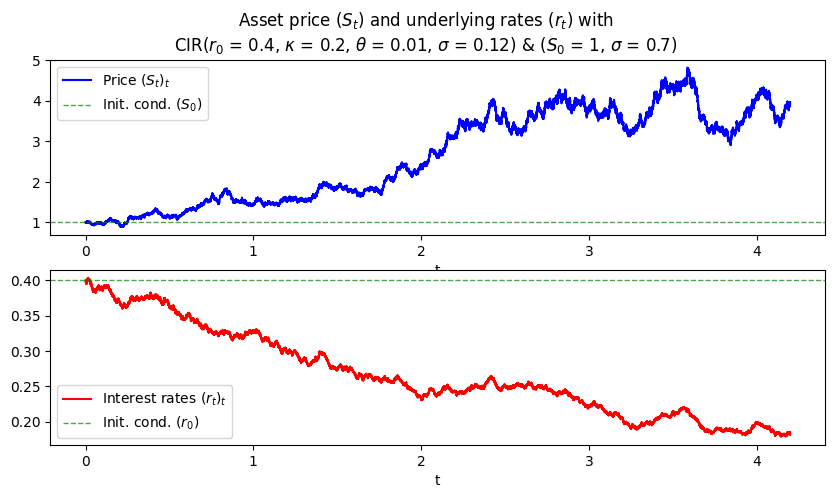

In [25]:
# Plotting the asset price and the interest rates evolution over time 
_, axes = plt.subplots(nrows=2, ncols=1)
_ = df.plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$", ax=axes[0])
_ = axes[0].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
_ = df.plot(x = "t", y = "r", color="red", label="Interest rates $(r_t)_t$", ax=axes[1])
_ = axes[1].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
axes[0].legend()
axes[1].legend()
_ = plt.suptitle(f"Asset price $(S_t)$ and underlying rates $(r_t)$ with\n{r.MODEL_NAME}{r.get_parameter_string()} & {model.get_parameter_string()}")

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Time-varying volatility</span>

In [ ]:
# Heston

## Analysis

### Distribution of $S_T$

In [ ]:
# Skewness, Kurtosis, Moments (basic statistics)

### Computation of derivatives price

#### European option pricing

In [2]:
# Model parameters
S0 = 4
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

In [30]:
# Define the European pricer
ep = EuropeanPricer(udl_model=model, preCompute=True, N_MC=100)

Pre-computing the equity trajectories
100


Sim. progress:   0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
ep

In [32]:
ep.trajectories

[             t         S         r
 0      0.00000  4.000000  0.400000
 1      0.00001  4.008448  0.400462
 2      0.00002  4.010243  0.400373
 3      0.00003  4.011743  0.400296
 4      0.00004  4.010331  0.400505
 ...        ...       ...       ...
 99995  0.99995  3.244058  0.336252
 99996  0.99996  3.245925  0.336401
 99997  0.99997  3.240027  0.336188
 99998  0.99998  3.240982  0.335998
 99999  0.99999  3.241414  0.335843
 
 [100000 rows x 3 columns],
              t         S         r
 0      0.00000  4.000000  0.400000
 1      0.00001  3.996041  0.400055
 2      0.00002  4.004811  0.400178
 3      0.00003  4.002273  0.399775
 4      0.00004  3.991635  0.399547
 ...        ...       ...       ...
 99995  0.99995  7.712859  0.391108
 99996  0.99996  7.708177  0.391388
 99997  0.99997  7.714309  0.391693
 99998  0.99998  7.691988  0.391404
 99999  0.99999  7.670318  0.391145
 
 [100000 rows x 3 columns],
              t         S         r
 0      0.00000  4.000000  0.400000
 1  

In [33]:
# Boolean representing whether the simulations have already been simulated
ep.isSimulated

True

In [34]:
ep.N_MC

100

In [35]:
if __name__ == "__main__":
    s = ep.simulate_samples_parallel(N_MC=100, N_PROC=7)

Number of processes: 7
Number of simulations: 100
Workload per process: 14
Init process
Init process
Init process
Init process
Init process
Init process
Init process
Getting results
14
Getting results
14
Getting results
14
Getting results
14
Getting results
14
Getting results
14
Getting results
14
Ending process
Ending process
Ending process
Ending process
Ending process
Ending process
Ending process


In [28]:
sum([len(k) for k in s])

98

In [29]:
100%7

2

In [31]:
K = 3.3
# Call price
pricer_res = ep.compute_option_price(K=K, 
                                     contract=Constants.Contract.CALL, 
                                     ci_levels=[
                                         Constants.Level.LEVEL_80, 
                                         Constants.Level.LEVEL_85, 
                                         Constants.Level.LEVEL_90,
                                         Constants.Level.LEVEL_95,
                                         Constants.Level.LEVEL_99_9
                                     ])
pricer_res


Required CI levels:  [80, 85, 90, 95, 99.9]


{'price': 1.861194619539947,
 'ci': {80: {'lower': 0.7640609698386456,
   'upper': 2.9583282692412483,
   'radius': 1.0971336497013013},
  85: {'lower': 0.6288448102030719,
   'upper': 3.0935444288768217,
   'radius': 1.232349809336875},
  90: {'lower': 0.4534061220683083,
   'upper': 3.2689831170115857,
   'radius': 1.4077884974716386},
  95: {'lower': 0.1838296012758669,
   'upper': 3.5385596378040267,
   'radius': 1.67736501826408},
  99.9: {'lower': -0.9552381738820366,
   'upper': 4.677627412961931,
   'radius': 2.8164327934219835}}}

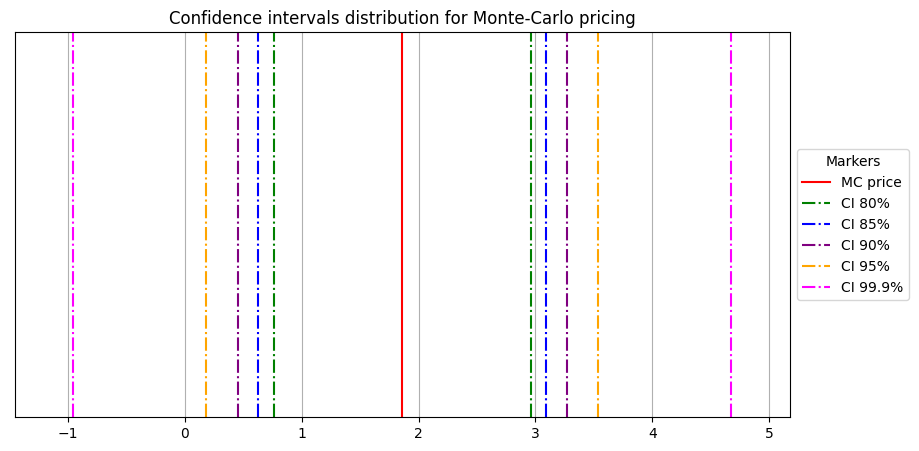

In [35]:
# Plot confidence intervals
Utils.plot_confidence_intervals(pricer_res)

In [11]:
# Call price
ep.compute_option_price_call(K)

Required CI levels:  [95]


{'price': 2.3953898786606387,
 'ci': {95: {'lower': 0.44400640734278074,
   'upper': 4.346773349978497,
   'radius': 1.951383471317858}}}

In [12]:
# Put price
ep.compute_option_price_put(K)

Required CI levels:  [95]


{'price': 0.4747794567891348,
 'ci': {95: {'lower': 0.1610600996305957,
   'upper': 0.7884988139476738,
   'radius': 0.3137193571585391}}}

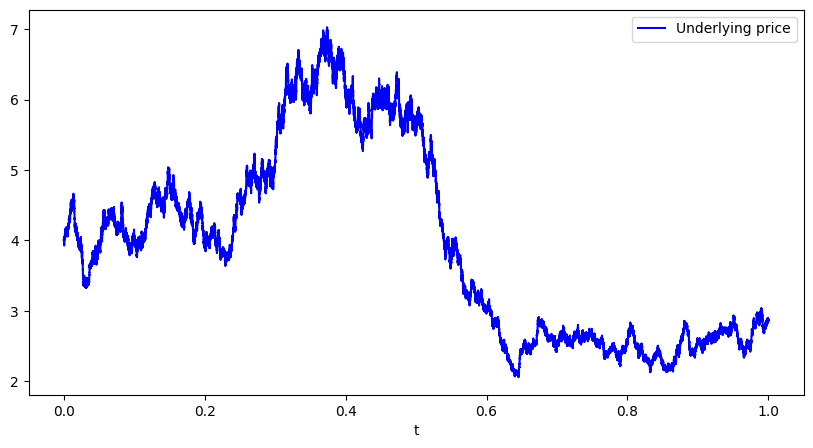

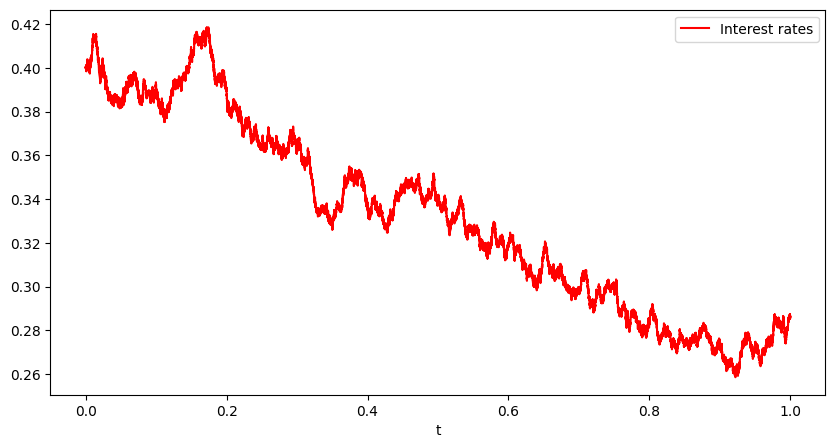

In [20]:
# Plotting underlying price and rates
_ = ep.trajectories[1].plot(y="S", x = "t", figsize=(10, 5), label="Underlying price", color="blue")
_ = ep.trajectories[1].plot(y="r", x = "t", figsize=(10, 5), label="Interest rates", color="red")

In [27]:
# Next step: study the evolution of MC


N_MC_ = np.arange(10, 350, 5)
K = 2
data = {N_MC: {"price": None, "ci": None, "exec_time": None} for N_MC in N_MC_}
for N_MC in N_MC_:
    print(f"Processing:\t {N_MC}")
    ep.isSimulated = False
    # Computing the call price using Monte-Carlo simulation
    start_time = time.time()
    pricer_res = ep.compute_option_price(K=K, 
                                         contract=Constants.Contract.CALL, 
                                         ci_levels=[
                                             Constants.Level.LEVEL_80, 
                                             Constants.Level.LEVEL_85, 
                                             Constants.Level.LEVEL_90
                                         ], N_MC=N_MC)
    end_time = time.time()
    duration = end_time - start_time
    
    # Retrieving the output from computations
    price, ci = Utils.get_dict_values(pricer_res)
    data[N_MC]["price"] = price
    data[N_MC]["ci"] = ci
    data[N_MC]["exec_time"] = duration
    

Processing:	 10


Sim. progress:   0%|          | 0/10 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 15


Sim. progress:   0%|          | 0/15 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 20


Sim. progress:   0%|          | 0/20 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 25


Sim. progress:   0%|          | 0/25 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 30


Sim. progress:   0%|          | 0/30 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 35


Sim. progress:   0%|          | 0/35 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 40


Sim. progress:   0%|          | 0/40 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 45


Sim. progress:   0%|          | 0/45 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 50


Sim. progress:   0%|          | 0/50 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 55


Sim. progress:   0%|          | 0/55 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 60


Sim. progress:   0%|          | 0/60 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 65


Sim. progress:   0%|          | 0/65 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 70


Sim. progress:   0%|          | 0/70 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 75


Sim. progress:   0%|          | 0/75 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 80


Sim. progress:   0%|          | 0/80 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 85


Sim. progress:   0%|          | 0/85 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 90


Sim. progress:   0%|          | 0/90 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 95


Sim. progress:   0%|          | 0/95 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 100


Sim. progress:   0%|          | 0/100 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 105


Sim. progress:   0%|          | 0/105 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 110


Sim. progress:   0%|          | 0/110 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 115


Sim. progress:   0%|          | 0/115 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 120


Sim. progress:   0%|          | 0/120 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 125


Sim. progress:   0%|          | 0/125 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 130


Sim. progress:   0%|          | 0/130 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 135


Sim. progress:   0%|          | 0/135 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 140


Sim. progress:   0%|          | 0/140 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 145


Sim. progress:   0%|          | 0/145 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 150


Sim. progress:   0%|          | 0/150 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 155


Sim. progress:   0%|          | 0/155 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 160


Sim. progress:   0%|          | 0/160 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 165


Sim. progress:   0%|          | 0/165 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 170


Sim. progress:   0%|          | 0/170 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 175


Sim. progress:   0%|          | 0/175 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 180


Sim. progress:   0%|          | 0/180 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 185


Sim. progress:   0%|          | 0/185 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 190


Sim. progress:   0%|          | 0/190 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 195


Sim. progress:   0%|          | 0/195 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 200


Sim. progress:   0%|          | 0/200 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 205


Sim. progress:   0%|          | 0/205 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 210


Sim. progress:   0%|          | 0/210 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 215


Sim. progress:   0%|          | 0/215 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 220


Sim. progress:   0%|          | 0/220 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 225


Sim. progress:   0%|          | 0/225 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 230


Sim. progress:   0%|          | 0/230 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 235


Sim. progress:   0%|          | 0/235 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 240


Sim. progress:   0%|          | 0/240 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 245


Sim. progress:   0%|          | 0/245 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 250


Sim. progress:   0%|          | 0/250 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 255


Sim. progress:   0%|          | 0/255 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 260


Sim. progress:   0%|          | 0/260 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 265


Sim. progress:   0%|          | 0/265 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 270


Sim. progress:   0%|          | 0/270 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 275


Sim. progress:   0%|          | 0/275 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 280


Sim. progress:   0%|          | 0/280 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 285


Sim. progress:   0%|          | 0/285 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 290


Sim. progress:   0%|          | 0/290 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 295


Sim. progress:   0%|          | 0/295 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 300


Sim. progress:   0%|          | 0/300 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 305


Sim. progress:   0%|          | 0/305 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 310


Sim. progress:   0%|          | 0/310 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 315


Sim. progress:   0%|          | 0/315 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 320


Sim. progress:   0%|          | 0/320 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 325


Sim. progress:   0%|          | 0/325 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 330


Sim. progress:   0%|          | 0/330 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 335


Sim. progress:   0%|          | 0/335 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 340


Sim. progress:   0%|          | 0/340 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]
Processing:	 345


Sim. progress:   0%|          | 0/345 [00:00<?, ?it/s]

Required CI levels:  [80, 85, 90]


In [28]:
a = pd.DataFrame(data)
a.head()

,10,15,20,25,30,35,40,45,50,55,...,300,305,310,315,320,325,330,335,340,345
price,2.84735,2.952357,2.671061,1.94501,2.651887,2.383898,3.456311,2.446848,2.951213,2.747495,...,2.859611,2.86375,2.445182,2.960706,2.694893,3.032536,2.6218,2.696869,2.657841,2.426091
ci,"{80: {'lower': 1.664332611323234, 'upper': 4.0...","{80: {'lower': 2.2849079791542257, 'upper': 3....","{80: {'lower': 1.4553532563143496, 'upper': 3....","{80: {'lower': 1.432871715935895, 'upper': 2.4...","{80: {'lower': 2.1149723719343094, 'upper': 3....","{80: {'lower': 1.8307640740811768, 'upper': 2....","{80: {'lower': 2.627956914082393, 'upper': 4.2...","{80: {'lower': 1.9835942320810709, 'upper': 2....","{80: {'lower': 2.3641152726388053, 'upper': 3....","{80: {'lower': 2.2310018866367374, 'upper': 3....",...,"{80: {'lower': 2.598246140914918, 'upper': 3.1...","{80: {'lower': 2.607559821030457, 'upper': 3.1...","{80: {'lower': 2.238843999777586, 'upper': 2.6...","{80: {'lower': 2.653230434142573, 'upper': 3.2...","{80: {'lower': 2.464395967255779, 'upper': 2.9...","{80: {'lower': 2.788831666380372, 'upper': 3.2...","{80: {'lower': 2.408265843548002, 'upper': 2.8...","{80: {'lower': 2.4973323247804036, 'upper': 2....","{80: {'lower': 2.4357772664313924, 'upper': 2....","{80: {'lower': 2.232379619608963, 'upper': 2.6..."
exec_time,3.185704,4.628557,6.07477,7.533555,10.491768,12.002736,13.242367,14.943453,16.067316,17.971506,...,94.380007,97.699127,98.166759,100.380241,100.134565,103.566259,104.910657,111.846153,109.720528,111.432083


In [94]:
a.T["ci"].apply(pd.Series)[80].apply(pd.Series)

,lower,upper,radius
10,1.664333,4.030367,1.183017
15,2.284908,3.619806,0.667449
20,1.455353,3.886770,1.215708
25,1.432872,2.457148,0.512138
30,2.114972,3.188802,0.536915
...,...,...,...
325,2.788832,3.276240,0.243704
330,2.408266,2.835333,0.213534
335,2.497332,2.896406,0.199537
340,2.435777,2.879905,0.222064


In [124]:
a.T["ci"].iloc[0].keys()

dict_keys([80, 85, 90])

In [127]:
a.to_pickle("export/CV_MC.pkl")

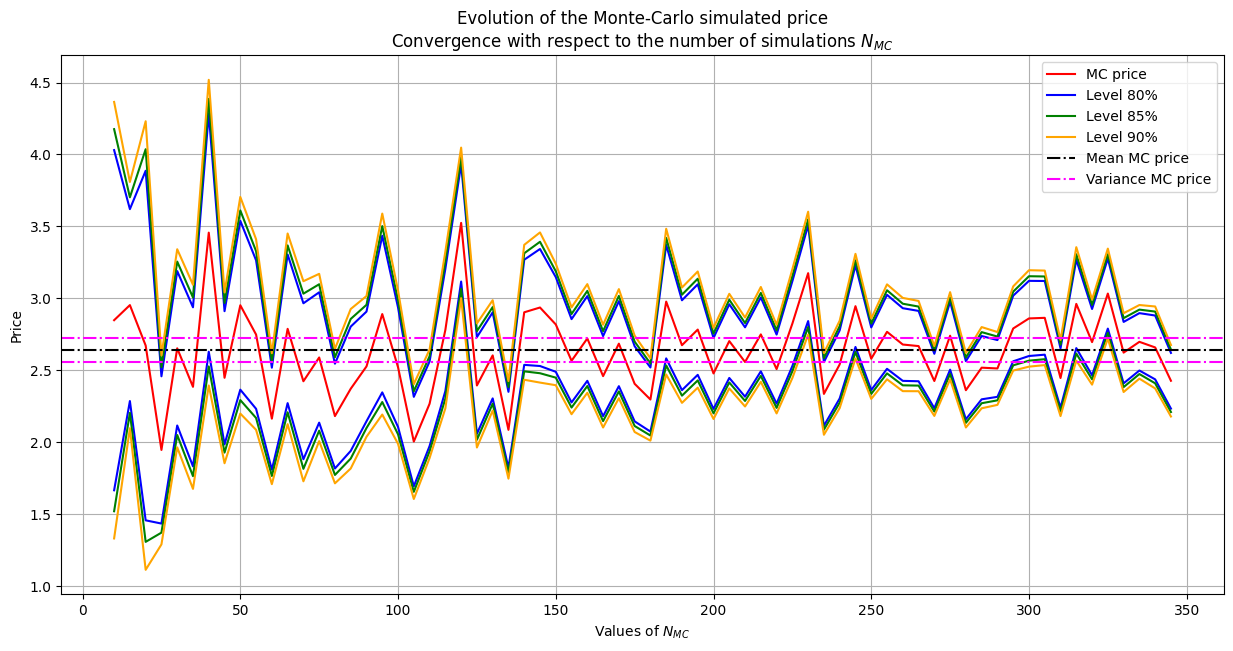

In [128]:
a.T["price"].plot(figsize=(15, 7), color="red", label="MC price")
colors = ["blue", "green", "orange", "purple", "magenta"]
for i, ci_level in enumerate(list(ci.keys())):
    a.T["ci"].apply(pd.Series)[ci_level].apply(pd.Series)["lower"].plot(color=colors[i], label=f"Level {ci_level}%")
    a.T["ci"].apply(pd.Series)[ci_level].apply(pd.Series)["upper"].plot(color=colors[i], label="")
_ = plt.axhline(y = a.T["price"].mean(), color="black", ls="-.", label="Mean MC price")
_ = plt.axhline(y = a.T["price"].mean() - a.T["price"].var(), color="magenta", ls="-.", label="Variance MC price")
_ = plt.axhline(y = a.T["price"].mean() + a.T["price"].var(), color="magenta", ls="-.", label="")
_ = plt.xlabel("Values of $N_{MC}$")
_ = plt.ylabel("Price")
_ = plt.title("Evolution of the Monte-Carlo simulated price\nConvergence with respect to the number of simulations $N_{MC}$")
_ = plt.legend()
_ = plt.grid()

In [ ]:
# Read Pickle

In [21]:
df = pd.read_pickle("export/CV_MC.pkl")

In [22]:
df

,10,15,20,25,30,35,40,45,50,55,...,300,305,310,315,320,325,330,335,340,345
price,2.84735,2.952357,2.671061,1.94501,2.651887,2.383898,3.456311,2.446848,2.951213,2.747495,...,2.859611,2.86375,2.445182,2.960706,2.694893,3.032536,2.6218,2.696869,2.657841,2.426091
ci,"{80: {'lower': 1.664332611323234, 'upper': 4.0...","{80: {'lower': 2.2849079791542257, 'upper': 3....","{80: {'lower': 1.4553532563143496, 'upper': 3....","{80: {'lower': 1.432871715935895, 'upper': 2.4...","{80: {'lower': 2.1149723719343094, 'upper': 3....","{80: {'lower': 1.8307640740811768, 'upper': 2....","{80: {'lower': 2.627956914082393, 'upper': 4.2...","{80: {'lower': 1.9835942320810709, 'upper': 2....","{80: {'lower': 2.3641152726388053, 'upper': 3....","{80: {'lower': 2.2310018866367374, 'upper': 3....",...,"{80: {'lower': 2.598246140914918, 'upper': 3.1...","{80: {'lower': 2.607559821030457, 'upper': 3.1...","{80: {'lower': 2.238843999777586, 'upper': 2.6...","{80: {'lower': 2.653230434142573, 'upper': 3.2...","{80: {'lower': 2.464395967255779, 'upper': 2.9...","{80: {'lower': 2.788831666380372, 'upper': 3.2...","{80: {'lower': 2.408265843548002, 'upper': 2.8...","{80: {'lower': 2.4973323247804036, 'upper': 2....","{80: {'lower': 2.4357772664313924, 'upper': 2....","{80: {'lower': 2.232379619608963, 'upper': 2.6..."
exec_time,3.185704,4.628557,6.07477,7.533555,10.491768,12.002736,13.242367,14.943453,16.067316,17.971506,...,94.380007,97.699127,98.166759,100.380241,100.134565,103.566259,104.910657,111.846153,109.720528,111.432083


#### Asian option pricing

In [13]:
# Model parameters
S0 = 4
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

In [14]:
# Define the Asian pricer
ap = AsianPricer(udl_model=model, preCompute=True, N_MC=10)

Pre-computing the equity trajectories


Sim. progress:   0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
ap

In [16]:
ap.isSimulated

True

In [17]:
K = 1
# Call price
ap.compute_option_price(K=K, contract=Constants.Contract.CALL)

2.629477380493443

In [21]:
# Call price
ap.compute_option_price_call(K)

2.629477380493443

In [22]:
# Put price
ap.compute_option_price_put(K)

0.0

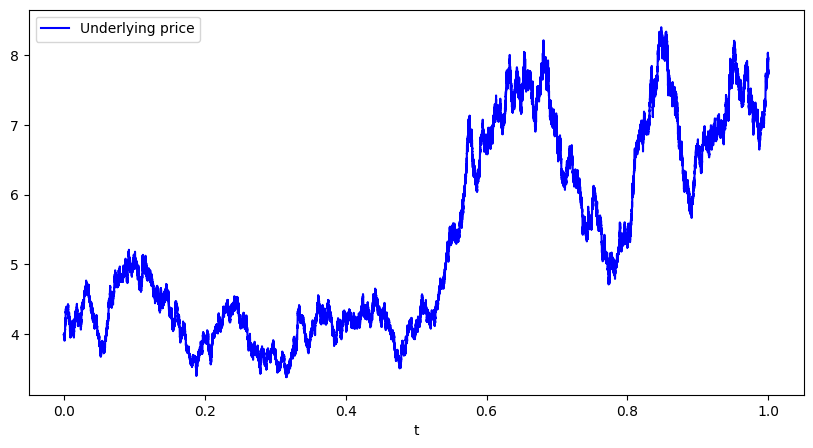

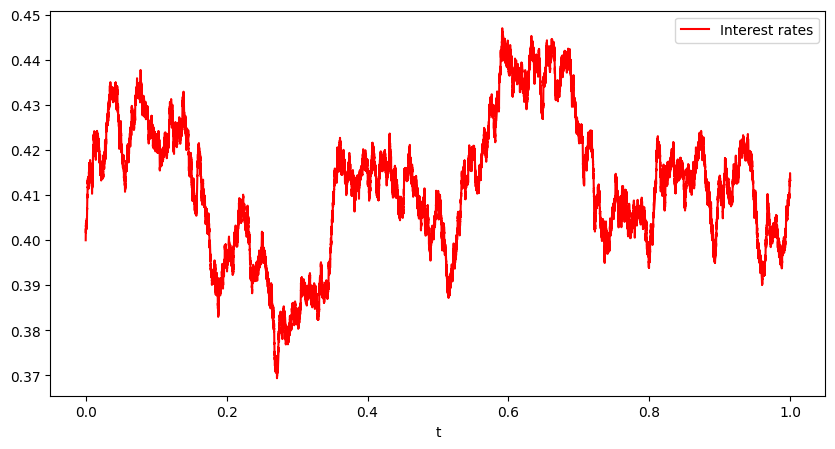

In [23]:
# Plotting underlying price and rates
_ = ap.trajectories[1].plot(y="S", x = "t", figsize=(10, 5), label="Underlying price", color="blue")
_ = ap.trajectories[1].plot(y="r", x = "t", figsize=(10, 5), label="Interest rates", color="red")

### Simulation of the joint distribution $\Big(\int_0^T r_u \mathrm{d}u, S_T\Big) $

---
**Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
